In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

2024-01-02 23:19:44.294192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 23:19:44.294228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 23:19:44.316707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 23:19:44.352293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

# A partir de aquí, puedes continuar con la construcción y entrenamiento de tu modelo de Keras

In [13]:
def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Data Load

In [30]:
from keras.preprocessing.image import ImageDataGenerator
import os

image_size = 224
batch_size = 16
rescale_factor = 1./255

# Directorio conjunto entrenamiento
data_dir='Project_Animals/animals/Train/'
test_dir='Project_Animals/animals/Test'


# Crear un generador para aumentar datos
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,    # Normalizar los valores de los píxeles
    shear_range=0.2,   # Rango para las transformaciones aleatorias
    zoom_range=0.2,    # Rango para el zoom aleatorio
    horizontal_flip=True, # Activar el giro horizontal aleatorio
    validation_split=0.2) # Establecer el porcentaje de imágenes para el conjunto de validación

# Cargar imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir,      # Directorio con datos
    target_size=(image_size, image_size), # Cambiar el tamaño de las imágenes a 50x50
    batch_size=batch_size,
    class_mode='categorical', # 'binary' para clasificación binaria, 'categorical' para multiclase
    subset='training') # Seleccionar solo el conjunto de entrenamiento

# Cargar imágenes de validación
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # Seleccionar solo el conjunto de validación

# Cargar imágenes de entrenamiento
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=16,
    class_mode='categorical'
)




Found 6462 images belonging to 6 classes.
Found 1614 images belonging to 6 classes.
Found 708 images belonging to 6 classes.


## Model

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Congelar las capas del modelo VGG16 preentrenado
for layer in base_model.layers:
    layer.trainable = False

# Crear un modelo secuencial
model = Sequential()

# Agregar el modelo VGG16 al modelo secuencial
model.add(base_model)

# Capas fully connected (clasificador)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))  # Usar 'softmax' para clasificación multi-clase

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                802848    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 15,517,734
Trainable params: 803,046
Non-trainable params: 14,714,688
_________________________________________________________________
None


## Train

In [16]:
from keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # 'patience' es el número de épocas sin mejora después de las cuales el entrenamiento se detendrá

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100

# Entrenar el modelo con Early Stopping
history_of_train = model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [early_stopping],
        steps_per_epoch=250
)

/tmp/ipykernel_27609/3427658837.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_of_train = model.fit_generator(


Epoch 1/100
250/250 [==============================] - 46s 181ms/step - loss: 1.3257 - accuracy: 0.4512 - val_loss: 0.8979 - val_accuracy: 0.7088
Epoch 2/100
250/250 [==============================] - 45s 180ms/step - loss: 0.9736 - accuracy: 0.6143 - val_loss: 0.7009 - val_accuracy: 0.7924
Epoch 3/100
250/250 [==============================] - 45s 179ms/step - loss: 0.8720 - accuracy: 0.6663 - val_loss: 0.5992 - val_accuracy: 0.8160
Epoch 4/100
250/250 [==============================] - 45s 180ms/step - loss: 0.7883 - accuracy: 0.7024 - val_loss: 0.5522 - val_accuracy: 0.8247
Epoch 5/100
250/250 [==============================] - 45s 179ms/step - loss: 0.7348 - accuracy: 0.7296 - val_loss: 0.5012 - val_accuracy: 0.8401
Epoch 6/100
250/250 [==============================] - 45s 181ms/step - loss: 0.6848 - accuracy: 0.7508 - val_loss: 0.4824 - val_accuracy: 0.8581
Epoch 7/100
250/250 [==============================] - 46s 184ms/step - loss: 0.6571 - accuracy: 0.7508 - val_loss: 0.4625 -

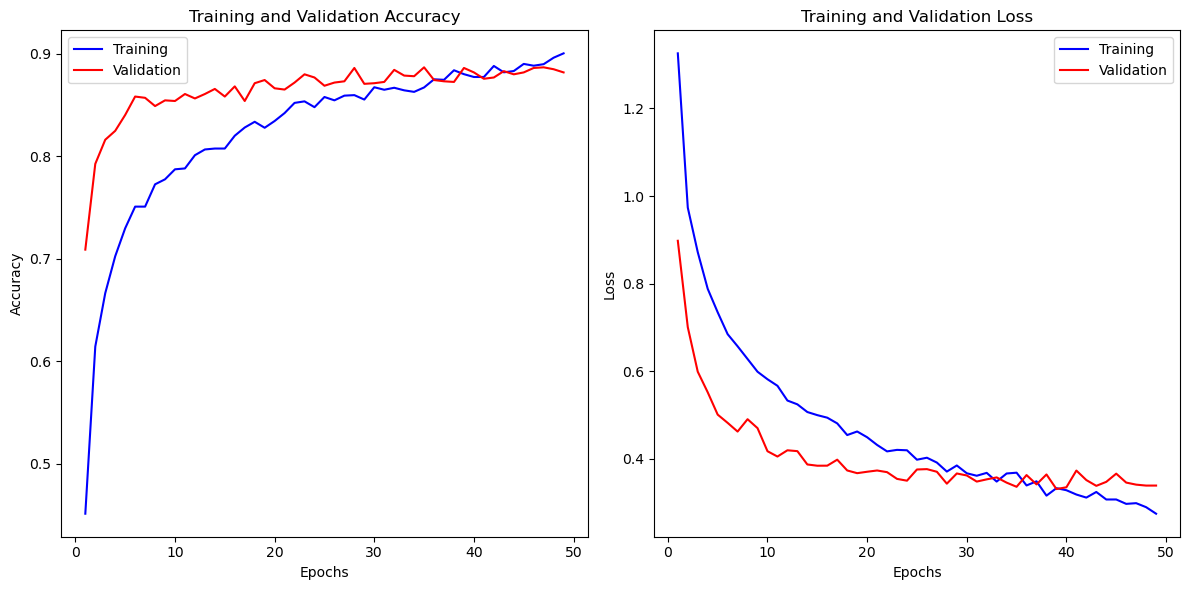

In [18]:
generatePlot(history_of_train)

## Test

In [283]:
# Evaluar el modelo en el conjunto de validación (usado aquí como prueba)
# Puedes limitar el número de pasos para usar solo una parte del conjunto
test_loss, test_accuracy = model.evaluate(test_generator)  # 'steps' es el número de lotes a evaluar

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

45/45 [==============================] - 8s 172ms/step - loss: 0.3620 - accuracy: 0.8686
Test Loss: 0.3619837760925293
Test Accuracy: 0.8686440587043762


In [20]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
model.save("mimodelo4.h5")


# LOADING --------------------------------------------------
model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas = ['Butterfly', 'Cat', 'Cow', 'Elephant', 'Sheep', 'Squirrel']
cantidad_pruebas = 5  # Número de pruebas que deseas realizar

print("ETIQUETA PREDICHA -> ETIQUETA REAL")
contador_pruebas = 0
for minilote in test_generator:
    if contador_pruebas >= cantidad_pruebas:
        break  # Salir del bucle después de realizar las 50 pruebas
        
    prediccion_minilote = model.predict(minilote[0])
    etiqueta_real_minilote = minilote[1]
    for y_predicha, y_real in zip(np.round(prediccion_minilote, 3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")
    
    contador_pruebas += 1


ETIQUETA PREDICHA -> ETIQUETA REAL
1/1 [==============================] - 0s 129ms/step
Elephant -> Elephant
Squirrel -> Squirrel
Sheep -> Sheep
Butterfly -> Butterfly
Cow -> Cow
Elephant -> Elephant
Cat -> Cat
Sheep -> Sheep
Squirrel -> Squirrel
Cow -> Cow
Squirrel -> Butterfly ✘
Elephant -> Elephant
Cat -> Cat
Squirrel -> Sheep ✘
Squirrel -> Squirrel
Squirrel -> Squirrel
1/1 [==============================] - 0s 20ms/step
Cow -> Cow
Sheep -> Cow ✘
Squirrel -> Squirrel
Sheep -> Sheep
Cow -> Cow
Cat -> Cat
Butterfly -> Butterfly
Cat -> Squirrel ✘
Cow -> Cow
Cat -> Cat
Elephant -> Elephant
Sheep -> Sheep
Elephant -> Elephant
Squirrel -> Sheep ✘
Butterfly -> Butterfly
Sheep -> Squirrel ✘
1/1 [==============================] - 0s 21ms/step
Cat -> Cat
Butterfly -> Butterfly
Sheep -> Sheep
Cat -> Cat
Cow -> Cow
Sheep -> Sheep
Squirrel -> Squirrel
Sheep -> Sheep
Butterfly -> Butterfly
Cow -> Cow
Cat -> Squirrel ✘
Butterfly -> Butterfly
Butterfly -> Butterfly
Sheep -> Sheep
Butterfly -> Butte